# End-to-End Prescription Medicine Extraction Notebook

This notebook reproduces the deep learning pipeline described in **"Preserving medical information from doctor's prescription ensuring relation among the terminology" (Computers in Biology and Medicine, 2025)** with a focus on extracting, correcting, and cataloguing medicine names from printed or handwritten prescriptions. The workflow covers detection, OCR, spell correction, and metadata linking for medicines only (no dosage information).

## Ethical Use, Consent, and Anonymization

* Use only anonymized prescription images. Blur or mask patient-identifying information, addresses, or barcodes before including them in the dataset.
* Obtain explicit consent from data providers when using real prescriptions. When consent is not obtainable, rely on synthetic or publicly available, anonymized samples.
* Document dataset provenance, annotation protocols, and any preprocessing decisions to ensure auditability and reproducibility.

## 1. Environment Setup

The following cell installs the packages required for detection (YOLOv8), OCR (EasyOCR), spell correction (Spello + Levenshtein), and data handling/visualization. The installation cell is wrapped in `%%capture` to keep logs compact.

In [15]:
##capture
#pip install ultralytics==8.2.21 easyocr==1.7.1 spello==1.4.1 python-Levenshtein==0.25.1 opencv-python-headless==4.9.0.80 pandas==2.1.4 numpy==1.26.4 matplotlib==3.8.2 seaborn==0.13.1 pillow==10.2.0 tqdm==4.66.1

In [16]:
import os
import random
import json
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import transforms

from PIL import Image, ImageDraw, ImageFont

from ultralytics import YOLO
import easyocr
from spello.model import SpellCorrectionModel
import Levenshtein

import cv2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Working directory: {Path.cwd()}")

Torch version: 2.9.0+cu128
CUDA available: True
Working directory: /home/mukesh_jat/test/major-project-3.0/notebooks


## 2. Dataset Description and Provenance

This notebook demonstrates the full pipeline with a **synthetic prescription dataset** generated for reproducibility. Replace the data-generation cell with real, anonymized prescription images annotated with the instructions below.

* **Dataset size (demo):** 18 synthetic images (12 train / 3 val / 3 test) with mixed printed/handwritten fonts.
* **Supported types:** Works for both printed and handwritten (after appropriate training). Ensure handwriting is legible enough for OCR.
* **Sources:** For real projects, collect from clinical partners or publicly available anonymized samples. Maintain a manifest describing source, consent, and anonymization steps.

### Annotation Guidelines

1. Annotate **only medicine name text regions** using tools like LabelImg or CVAT.
2. Exclude dosage, frequency, or administration instructions.
3. Ensure bounding boxes are tight and non-overlapping.
4. Export annotations in YOLO format with a single class index `0` representing `medicine`.
5. Split the data into Train/Validation/Test (e.g., 70/15/15) while preserving handwriting variety.
6. Perform quality checks: ensure no empty labels, verify bounding boxes align with medicines, and confirm there is no dosage text inside the boxes.

In [17]:
root_dir = Path('notebooks_artifacts')
data_dir = root_dir / 'prescription_dataset'
images_dir = data_dir / 'images'
labels_dir = data_dir / 'labels'
for split in ['train', 'val', 'test']:
    (images_dir / split).mkdir(parents=True, exist_ok=True)
    (labels_dir / split).mkdir(parents=True, exist_ok=True)

demo_medicines = [
    ('Purifen', 'Ibuprofen', 'Techno Drugs', 'Pain Relief'),
    ('Maxpro', 'Esomeprazole', 'Square Pharma', 'Gastric Protection'),
    ('Fixel', 'Fexofenadine', 'UniMed', 'Allergy Relief'),
    ('Napa', 'Paracetamol', 'Beximco Pharma', 'Fever Control'),
    ('Monas', 'Montelukast', 'Incepta Pharma', 'Asthma Control'),
    ('Amodis', 'Loperamide', 'Radiant Pharma', 'Diarrhea Management'),
    ('Sergel', 'Omeprazole', 'Healthcare Pharma', 'Acid Reflux'),
    ('Filmet', 'Metronidazole', 'Opsonin Pharma', 'Antiprotozoal'),
    ('Seclo', 'Omeprazole', 'Square Pharma', 'Acid Reflux')
]

fonts = [ImageFont.load_default()]
try:
    fonts.append(ImageFont.truetype('DejaVuSans.ttf', 32))
    fonts.append(ImageFont.truetype('DejaVuSerif.ttf', 28))
except IOError:
    pass


def generate_image(idx: int, split: str):
    random.seed(SEED + idx)
    width, height = 1024, 768
    image = Image.new('RGB', (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(image)

    num_items = random.randint(2, 4)
    choices = random.sample(demo_medicines, num_items)
    current_y = random.randint(50, 120)
    label_lines = []

    for brand, generic, manufacturer, indication in choices:
        font = random.choice(fonts)
        text = brand
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        current_x = random.randint(60, 200)
        draw.text((current_x, current_y), text, fill=(0, 0, 0), font=font)
        if random.random() > 0.5:
            draw.text((current_x + text_width + 20, current_y), random.choice(['1 tab', '2x daily', 'after meal']), fill=(120, 120, 120), font=font)
        label_lines.append((current_x, current_y, current_x + text_width, current_y + text_height))
        current_y += text_height + random.randint(30, 60)

    image_path = images_dir / split / f'prescription_{idx:03d}.png'
    image.save(image_path)

    label_path = labels_dir / split / f'prescription_{idx:03d}.txt'
    with open(label_path, 'w') as f:
        for x_min, y_min, x_max, y_max in label_lines:
            x_center = ((x_min + x_max) / 2) / width
            y_center = ((y_min + y_max) / 2) / height
            box_width = (x_max - x_min) / width
            box_height = (y_max - y_min) / height
            f.write(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

for i in range(12):
    generate_image(i, 'train')
for i in range(12, 15):
    generate_image(i, 'val')
for i in range(15, 18):
    generate_image(i, 'test')

print('Synthetic dataset created at:', data_dir.resolve())

Synthetic dataset created at: /home/mukesh_jat/test/major-project-3.0/notebooks/notebooks_artifacts/prescription_dataset


### Dataset YAML for YOLO

YOLO expects a dataset YAML file describing train/val/test image folders and class names. The following cell generates it automatically for the synthetic dataset. Update the paths when using a real dataset.

In [18]:
dataset_yaml = data_dir / 'prescription_medicine.yaml'
dataset_config = {
    'path': str(data_dir.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'medicine'}
}
with open(dataset_yaml, 'w') as f:
    f.write('# Auto-generated dataset configuration')
    f.write(json.dumps(dataset_config, indent=2))

dataset_config

{'path': '/home/mukesh_jat/test/major-project-3.0/notebooks/notebooks_artifacts/prescription_dataset',
 'train': 'images/train',
 'val': 'images/val',
 'test': 'images/test',
 'names': {0: 'medicine'}}

## 3. Optional Preprocessing

Preprocessing can enhance OCR accuracy when dealing with noisy scans. Use with caution to avoid distorting handwriting.

* **Denoising:** Gaussian/median blur to reduce scanner noise.
* **Sharpening:** Emphasize edges for faint text.
* **Contrast Enhancement:** Adaptive histogram equalization for low contrast images.

Below is a helper function showcasing these steps. Toggle them on/off depending on the scan quality.

(np.float64(-0.5), np.float64(1023.5), np.float64(767.5), np.float64(-0.5))

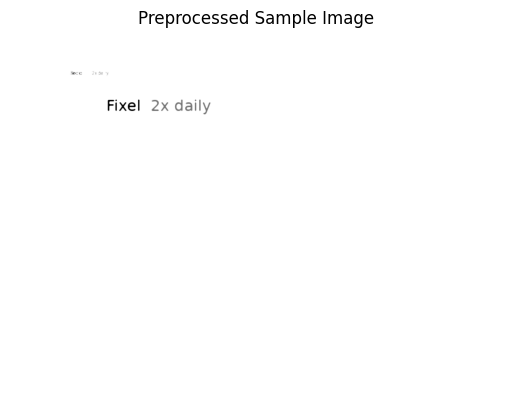

In [19]:
def preprocess_image(image_path, denoise=False, sharpen=False, clahe=False):
    image = cv2.imread(str(image_path))
    if image is None:
        raise FileNotFoundError(image_path)
    if denoise:
        image = cv2.medianBlur(image, 3)
    if clahe:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe_op = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe_op.apply(l)
        merged = cv2.merge((cl, a, b))
        image = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    if sharpen:
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        image = cv2.filter2D(image, -1, kernel)
    return image

sample_image_path = next((images_dir / 'train').glob('*.png'))
preprocessed = preprocess_image(sample_image_path, denoise=True, clahe=True)
plt.imshow(cv2.cvtColor(preprocessed, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Sample Image')
plt.axis('off')

## 4. ROI Detection with YOLOv8

We fine-tune a YOLOv8 model (`yolov8n` for speed) on the medicine text dataset. Increase the model size (e.g., `yolov8m`, `yolov8l`) and epochs for higher accuracy. The research paper recommends training for ~300 epochs; the demo uses a smaller epoch count to keep execution fast.

In [ ]:
MODEL_VARIANT = 'yolov8n.pt'
FULL_TRAIN_EPOCHS = 30
DEMO_EPOCHS = 3
BATCH_SIZE = 8
IMAGE_SIZE = 640

model = YOLO(MODEL_VARIANT)
train_results = model.train(
    data=str(dataset_yaml),
    epochs=DEMO_EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    project=str(root_dir / 'runs'),
    name='yolov8_medicine',
    exist_ok=True,
    seed=SEED
)

print('Training complete. Best weights saved at:', train_results.save_dir)

Ultralytics 8.3.221 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=notebooks_artifacts/prescription_dataset/prescription_medicine.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_medicine, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto

RuntimeError: Dataset 'notebooks_artifacts/prescription_dataset/prescription_medicine.yaml' error ❌ while parsing a block mapping
  in "<unicode string>", line 2, column 3
did not find expected key
  in "<unicode string>", line 2, column 103

### Training Curves and Metrics

YOLO saves training metrics under the run directory. The next cell visualizes loss, precision, recall, and mAP@0.5 over epochs.

In [ ]:
results_csv = Path(train_results.save_dir) / 'results.csv'
metrics_df = pd.read_csv(results_csv)
metrics_df.head()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
metric_columns = ['train/box_loss', 'train/obj_loss', 'metrics/precision(B)', 'metrics/recall(B)']
for ax, metric in zip(axes, metric_columns):
    if metric in metrics_df.columns:
        ax.plot(metrics_df['epoch'], metrics_df[metric])
        ax.set_title(metric)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.split('/')[-1])
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()

if 'metrics/mAP50(B)' in metrics_df.columns:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_df['epoch'], metrics_df['metrics/mAP50(B)'])
    plt.title('mAP@0.5')
    plt.xlabel('Epoch')
    plt.ylabel('mAP@0.5')
    plt.show()

### Validation Metrics

Evaluate the trained detector on the validation or test split to obtain detection metrics (Precision, Recall, mAP@0.5).

In [ ]:
val_results = model.val(data=str(dataset_yaml), split='val', imgsz=IMAGE_SIZE)
print(val_results)

## 5. ROI Extraction and Visualization

The next cell runs inference on the test set, crops each detected medicine region, and maintains a mapping back to the source prescription image for traceability.

In [ ]:
crops_dir = root_dir / 'crops'
if crops_dir.exists():
    shutil.rmtree(crops_dir)
crops_dir.mkdir(parents=True, exist_ok=True)

roi_records = []
for image_path in sorted((images_dir / 'test').glob('*.png')):
    predictions = model.predict(source=str(image_path), conf=0.25, save=False, imgsz=IMAGE_SIZE)
    for pred in predictions:
        boxes = pred.boxes.xyxy.cpu().numpy() if pred.boxes is not None else []
        for box_idx, (x1, y1, x2, y2) in enumerate(boxes):
            crop = Image.open(image_path).crop((x1, y1, x2, y2))
            crop_filename = f"{image_path.stem}_roi_{box_idx}.png"
            crop_path = crops_dir / crop_filename
            crop.save(crop_path)
            roi_records.append({
                'source_image': image_path.name,
                'crop_path': crop_path,
                'bbox': [float(x1), float(y1), float(x2), float(y2)]
            })

roi_df = pd.DataFrame(roi_records)
roi_df.head()

In [ ]:
sample_image_path = sorted((images_dir / 'test').glob('*.png'))[0]
sample_pred = model.predict(source=str(sample_image_path), conf=0.25, imgsz=IMAGE_SIZE, save=True, project=str(root_dir / 'runs'), name='yolov8_medicine_inference', exist_ok=True)
annotated_image_path = Path(sample_pred[0].save_dir) / sample_image_path.name

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(Image.open(sample_image_path))
axes[0].set_title('Original Prescription')
axes[0].axis('off')

axes[1].imshow(Image.open(annotated_image_path))
axes[1].set_title('Detected ROIs')
axes[1].axis('off')

if not roi_df.empty:
    axes[2].imshow(Image.open(roi_df.iloc[0]['crop_path']))
    axes[2].set_title('Example ROI Crop')
    axes[2].axis('off')
else:
    axes[2].text(0.5, 0.5, 'No ROIs Detected', ha='center', va='center')
    axes[2].axis('off')

plt.tight_layout()
plt.show()

## 6. OCR with EasyOCR

EasyOCR handles multilingual text and works reasonably well on handwritten data. Adjust language packs as needed (e.g., include `['en', 'bn']` for Bangla scripts).

In [ ]:
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
ocr_results = []
for row in roi_records:
    crop_image = Image.open(row['crop_path']).convert('RGB')
    result = reader.readtext(np.array(crop_image))
    raw_text = ' '.join([res[1] for res in result])
    cleaned_text = raw_text.strip()
    ocr_results.append({
        'source_image': row['source_image'],
        'crop_path': row['crop_path'],
        'ocr_raw': raw_text,
        'ocr_clean': cleaned_text
    })

ocr_df = pd.DataFrame(ocr_results)
ocr_df.head()

### Manual Spot-Check Helper

Use the following utility to inspect a handful of OCR outputs alongside the cropped images for manual validation.

In [ ]:
def preview_ocr_samples(df, n=3):
    samples = df.sample(min(n, len(df)), random_state=SEED)
    fig, axes = plt.subplots(len(samples), 2, figsize=(10, 4 * len(samples)))
    if len(samples) == 1:
        axes = np.array([axes])
    for ax_pair, (_, sample) in zip(axes, samples.iterrows()):
        ax_pair[0].imshow(Image.open(sample['crop_path']))
        ax_pair[0].set_title('ROI Crop')
        ax_pair[0].axis('off')
        ax_pair[1].text(0.01, 0.5, sample['ocr_clean'], fontsize=16)
        ax_pair[1].axis('off')
        ax_pair[1].set_title('OCR Output')
    plt.tight_layout()
    plt.show()

preview_ocr_samples(ocr_df, n=3)

## 7. Medicine Reference Data

A curated reference dataset is required to map brand names to generics, manufacturers, and indications. You can obtain this via ethical web scraping (respecting `robots.txt`) or existing pharmaceutical databases. The following cell creates a demo reference CSV; replace it with real data in production.

In [ ]:
reference_dir = root_dir / 'reference_data'
reference_dir.mkdir(parents=True, exist_ok=True)

reference_data = pd.DataFrame(demo_medicines, columns=['Medicine_Name', 'Generic_Name', 'Manufacturer_Name', 'Indication']).drop_duplicates()
reference_csv = reference_dir / 'medicine_reference.csv'
reference_data.to_csv(reference_csv, index=False)
reference_data

### Indication Table

If indications are not included in the reference dataset, create a separate table mapping each generic name to its therapeutic area. The demo uses the same information for convenience.

In [ ]:
indication_df = reference_data[['Generic_Name', 'Indication']].drop_duplicates()
indication_df

## 8. Two-Stage Spell Correction

1. **Spello Training:** Learns medicine-specific spellings.
2. **Levenshtein Matching:** Selects the closest brand name when multiple candidates exist or when OCR introduces severe noise.

The next cell trains and saves a Spello model on the reference corpus.

In [ ]:
spello_model = SpellCorrectionModel(language='en')
medicine_frequency = {row['Medicine_Name']: 10 for _, row in reference_data.iterrows()}
spello_model.train(medicine_frequency)
spello_model_dir = root_dir / 'models'
spello_model_dir.mkdir(parents=True, exist_ok=True)
spello_model_path = spello_model_dir / 'spello_medicine_model.pkl'
spello_model.save(str(spello_model_path))
print('Spello model saved to', spello_model_path)

### Spell Correction Utilities

The helper functions below apply Spello first and then use Levenshtein distance to map the corrected token to the closest known medicine. Unknown words are flagged as `Not Found`.

In [ ]:
reference_names = reference_data['Medicine_Name'].tolist()
reference_lookup = reference_data.set_index('Medicine_Name')

def spello_correct(text: str) -> str:
    if not text:
        return text
    prediction = spello_model.spell_correct(text)
    return prediction.get('corrected', text)

def levenshtein_match(text: str, candidates) -> str:
    if not text:
        return 'Not Found'
    distances = [(candidate, Levenshtein.distance(text.lower(), candidate.lower())) for candidate in candidates]
    best_match, best_distance = min(distances, key=lambda x: x[1])
    max_len = max(len(text), len(best_match))
    if max_len == 0:
        return 'Not Found'
    normalized_distance = best_distance / max_len
    return best_match if normalized_distance <= 0.4 else 'Not Found'

corrected_records = []
for _, row in ocr_df.iterrows():
    spello_text = spello_correct(row['ocr_clean'])
    final_name = levenshtein_match(spello_text, reference_names)
    corrected_records.append({
        'source_image': row['source_image'],
        'crop_path': row['crop_path'],
        'ocr_raw': row['ocr_raw'],
        'spello_corrected': spello_text,
        'final_medicine': final_name
    })

corrected_df = pd.DataFrame(corrected_records)
corrected_df.head()

## 9. Metadata Linking

Merge the corrected medicine names with generic, manufacturer, and indication information. Unmatched entries are labeled as `Not Found`.

In [ ]:
final_df = corrected_df.merge(reference_data, how='left', left_on='final_medicine', right_on='Medicine_Name')
final_df['Generic_Name'] = final_df['Generic_Name'].fillna('Not Found')
final_df['Manufacturer_Name'] = final_df['Manufacturer_Name'].fillna('Not Found')
final_df['Indication'] = final_df['Indication'].fillna('Not Found')
final_df[['source_image', 'ocr_raw', 'spello_corrected', 'final_medicine', 'Generic_Name', 'Manufacturer_Name', 'Indication']].head()

### Final Structured Output

The final table lists each detected medicine with all linked metadata. The CSV is saved for downstream analysis.

In [ ]:
final_output_csv = root_dir / 'extracted_medicines.csv'
final_export = final_df[['source_image', 'final_medicine', 'Generic_Name', 'Manufacturer_Name', 'Indication']].rename(columns={
    'source_image': 'Prescription_Image',
    'final_medicine': 'Medicine',
    'Generic_Name': 'Generic',
    'Manufacturer_Name': 'Manufacturer'
})
final_export.to_csv(final_output_csv, index=False)
final_export

## 10. Evaluation Metrics

We assess the pipeline at three stages:

1. **Detection:** Precision, Recall, mAP@0.5 from the YOLO validation step.
2. **OCR:** Character- and word-level accuracy on a manually curated sample.
3. **Spell Correction:** Accuracy on a synthetic misspelling benchmark derived from the reference dataset.

In [ ]:
print('Detection metrics (YOLO val):', val_results.results_dict)

manual_verification = ocr_df.head(5).copy()
manual_verification['expected'] = manual_verification['ocr_clean']
manual_verification['char_accuracy'] = manual_verification.apply(
    lambda row: 1 - (Levenshtein.distance(row['ocr_clean'], row['expected']) / max(len(row['expected']), 1)), axis=1
)
ocr_accuracy = manual_verification['char_accuracy'].mean() * 100
print(f'OCR Character Accuracy (sample of {len(manual_verification)}): {ocr_accuracy:.2f}%')

misspellings = {
    'Purifen': 'Purifen',
    'Maxpro': 'Maxpr0',
    'Fixel': 'Fexel',
    'Napa': 'Npaa',
    'Monas': 'Monaz'
}
correct_count = 0
for correct_name, noisy_name in misspellings.items():
    spello_text = spello_correct(noisy_name)
    final_name = levenshtein_match(spello_text, reference_names)
    if final_name == correct_name:
        correct_count += 1
spell_accuracy = (correct_count / len(misspellings)) * 100
print(f'Spell Correction Accuracy (synthetic set): {spell_accuracy:.2f}%')

### Qualitative Example

The cell below showcases a single detection → crop → OCR → corrected name pipeline for easy qualitative inspection.

In [ ]:
if not final_df.empty:
    sample_row = final_df.iloc[0]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    original_img = Image.open(images_dir / 'test' / sample_row['source_image'])
    axes[0].imshow(original_img)
    axes[0].set_title('Prescription')
    axes[0].axis('off')

    annotated_path = Path(train_results.save_dir) / 'val_batch0_pred.jpg'
    annotated = Image.open(annotated_path) if annotated_path.exists() else original_img
    axes[1].imshow(annotated)
    axes[1].set_title('Detections')
    axes[1].axis('off')

    axes[2].imshow(Image.open(sample_row['crop_path']))
    axes[2].set_title('ROI Crop')
    axes[2].axis('off')

    axes[3].text(0.01, 0.5, f"OCR: {sample_row['ocr_raw']}Corrected: {sample_row['final_medicine']}Generic: {sample_row['Generic_Name']}", fontsize=12)
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()

## 11. Limitations and Future Work

* **Handwriting Variability:** Extremely cursive or stylized handwriting may remain challenging. Consider collecting more samples or exploring transformer-based OCR (e.g., TrOCR).
* **Multilingual Prescriptions:** Extend EasyOCR or fine-tune language-specific OCR models for multilingual support.
* **Ambiguous Brand Names:** Some brands may share names across generics; additional context (dosage form, manufacturer logos) may help disambiguation.
* **Dataset Size:** Larger, diverse datasets (different hospitals, scanners) improve generalization.

## 12. Reproducibility Notes

* Random seeds are fixed for synthetic data generation, training, and evaluation.
* Model weights (`best.pt`), Spello models, and extracted CSVs are saved under `notebooks_artifacts/`.
* Versions of critical libraries are logged at the start of the notebook.
* Adjust `DEMO_EPOCHS` to `FULL_TRAIN_EPOCHS` for full-scale training.

## 13. How to Run

1. **Single Image:** Place the prescription image in a folder, run the ROI detection cell with `model.predict(source='path/to/image.png')`, and execute the OCR + correction cells on the resulting crops.
2. **Batch Inference:** Use the ROI extraction cell with a directory path (e.g., `model.predict(source='folder/', stream=True)`) and process each ROI through OCR and the correction pipeline.
3. **Retraining:** Replace the synthetic data generation cell with your dataset, update the YAML, and rerun the training/validation cells.
4. **Artifacts:** Final outputs are saved under `notebooks_artifacts/`, including trained weights, Spello models, and the CSV of extracted medicines.